In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
df = pd.read_csv('data/books.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 55 columns):
Unnamed: 0                1041 non-null int64

Dewey Decimal
           236 non-null object

Publication date
        876 non-null object

Published in English
    27 non-null object
Alma mater                4 non-null object
Artists                   1 non-null object
Audio read by             49 non-null object
Author                    1021 non-null object
Authors                   1 non-null object
Award                     13 non-null object
Awards                    30 non-null object
Born                      15 non-null object
Children                  1 non-null object
Citizenship               1 non-null object
Colorist                  1 non-null object
Country                   957 non-null object
Cover artist              503 non-null object
Date                      1 non-null object
Date of publication       1 non-null object
Died                      3 non-null ob

In [4]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

In [5]:
keep = ['author', 'country','genre','isbn','language','pages',
        'publisher','summary','title']

In [6]:
df = df[keep]

In [7]:
df.shape

(1041, 9)

In [8]:
df.head()

,author,country,genre,isbn,language,pages,publisher,summary,title
0,David Anthony Durham,United States,Fantasy fiction novel,0-385-50606-6,English,592 pp,Doubleday,Acacia: The War with the Mein is a 2007 novel ...,Acacia: The War with the Mein
1,Sir Henry Newbolt,United Kingdom,Fantasy novel,NaN,English,362 pp.,William Blackwood and Sons,Aladore is a classic allegorical fantasy novel...,Aladore
2,Lewis Carroll,United Kingdom,Fiction,NaN,English,NaN,Macmillan,Alice's Adventures in Wonderland (commonly sho...,Alice's Adventures in Wonderland
3,Patricia A. McKillip,United States,Fantasy novel,"0-441-01130-6 (first edition, hardback)",English,"314 (first edition, hardback)",Ace Books,Alphabet of Thorn is a 2004 fantasy novel writ...,Alphabet of Thorn
4,Michael Chabon,United States,Historical fiction,0-679-45004-1,English,639 pp,Random House,The Amazing Adventures of Kavalier & Clay is a...,The Amazing Adventures of Kavalier & Clay


In [9]:
df['pages'] = df['pages'].str.extract('(\d+)')

In [10]:
df['pages'] = pd.to_numeric(df['pages'], errors='coerce')

In [11]:
df.pages.fillna(0,inplace=True)

In [12]:
df['pages'] = df.pages.astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 9 columns):
author       1021 non-null object
country      957 non-null object
genre        1001 non-null object
isbn         637 non-null object
language     988 non-null object
pages        1041 non-null int64
publisher    882 non-null object
summary      1041 non-null object
title        1024 non-null object
dtypes: int64(1), object(8)
memory usage: 73.3+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104d6eda0>]],
      dtype=object)

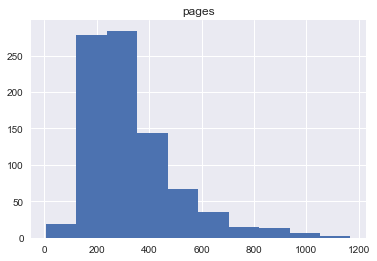

In [14]:
df[df.pages>0].hist()

In [15]:
df = df.dropna(subset=['title','author'])

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Linear Kernel is faster than cosine_similarities
from sklearn.metrics.pairwise import linear_kernel

# Parse the stringified features into their corresponding python objects
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [100]:
def get_recommendations(title,cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    book_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return df['title'].iloc[book_indices]

In [101]:
def create_soup(x):
    return x['author'] + ' ' +x['summary'] + ' ' + x['publisher'] + ' ' + x['country']

In [102]:
features = ['author','summary','publisher','country']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [103]:
df['soup'] = df.apply(create_soup,axis=1)

In [104]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df.soup)

In [105]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [106]:
#df = df.reset_index()
indices = pd.Series(df.index, index=df['title'])

In [107]:
get_recommendations('American Gods')

176                Orlando: A Biography
849     Something Wicked This Way Comes
1011                               Worm
268             The Wolves in the Walls
510                Flowers for Algernon
67                            Fledgling
507                           Fledgling
944                              Uglies
945                              Uglies
820                   Saturn's Children
Name: title, dtype: object

## Try with TF-IDF

In [108]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['soup'])
tfidf_matrix.shape

(1019, 143440)

In [109]:
cosine_sim2 = cosine_similarity(tfidf_matrix,tfidf_matrix)

In [110]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [111]:
get_recommendations('American Gods', cosine_sim2)

912                                          Template
849                   Something Wicked This Way Comes
176                              Orlando: A Biography
165                                        Neverwhere
93                                         The Hobbit
510                              Flowers for Algernon
268                           The Wolves in the Walls
297              Aleriel, or A Voyage to Other Worlds
247    The Water-Babies, A Fairy Tale for a Land Baby
78                                         Good Omens
Name: title, dtype: object

In [112]:
get_recommendations("Ender's Game",cosine_sim2)

485           Ender's Shadow
489           Ender in Exile
482     Speaker for the Dead
861     Speaker for the Dead
486           Shadow Puppets
863           Shadow Puppets
865        Shadows in Flight
883        Starship Troopers
483                 Xenocide
1013                Xenocide
Name: title, dtype: object

In [118]:
get_recommendations("Ender's Game")

485                   Ender's Shadow
489                   Ender in Exile
482             Speaker for the Dead
861             Speaker for the Dead
883                Starship Troopers
534                   The Glass Bees
625        The Left Hand of Darkness
106                         Brisingr
118    Jonathan Strange & Mr Norrell
987            The War of the Worlds
Name: title, dtype: object

In [113]:
get_recommendations("Dune",cosine_sim2)

625                          The Left Hand of Darkness
883                                  Starship Troopers
463                                       Dune Messiah
706    The Narrative of Arthur Gordon Pym of Nantucket
497                                     Fahrenheit 451
987                              The War of the Worlds
311                                     Atlas Shrugged
269                         The Wonderful Wizard of Oz
93                                          The Hobbit
249                                     Watership Down
Name: title, dtype: object

In [114]:
get_recommendations("Howl's Moving Castle",cosine_sim2)

744    The Sea of Monsters
93              The Hobbit
293          Alas, Babylon
336                  Black
193             Roverandom
209               Stardust
144         M Is for Magic
33                Cold Tom
272     The Worm Ouroboros
316     A Princess of Mars
Name: title, dtype: object

In [115]:
get_recommendations("The Haunting of Hill House",cosine_sim2)

591                The Island of Doctor Moreau
307                            Desolation Road
444                            Desolation Road
828               The Secret of Saturn's Rings
650     Lucky Starr and the Big Sun of Mercury
547                    Halo: The Fall of Reach
760                               Player Piano
665             The Master: An Adventure Story
273                          A Wrinkle in Time
1012                         A Wrinkle in Time
Name: title, dtype: object

In [116]:
get_recommendations("The Hobbit",cosine_sim2)

883                                  Starship Troopers
193                                         Roverandom
131                              The Lays of Beleriand
706    The Narrative of Arthur Gordon Pym of Nantucket
497                                     Fahrenheit 451
191                        Red Moon and Black Mountain
202                                   The Silmarillion
625                          The Left Hand of Darkness
311                                     Atlas Shrugged
141                             The Book of Lost Tales
Name: title, dtype: object

In [117]:
get_recommendations("The Hobbit")

883                                  Starship Troopers
193                                         Roverandom
706    The Narrative of Arthur Gordon Pym of Nantucket
625                          The Left Hand of Darkness
131                              The Lays of Beleriand
497                                     Fahrenheit 451
118                      Jonathan Strange & Mr Norrell
202                                   The Silmarillion
311                                     Atlas Shrugged
191                        Red Moon and Black Mountain
Name: title, dtype: object

In [119]:
get_recommendations("Cat's Cradle",cosine_sim2)

348         Breakfast of Champions
143    May Bird and the Ever After
323                 Swords of Mars
255             The Whitby Witches
391               Consider Phlebas
403               Consider Phlebas
845            Slaughterhouse-Five
689                 Moon of Mutiny
244         The War of the Flowers
34                        Coraline
Name: title, dtype: object

In [120]:
get_recommendations("Cat's Cradle")

176           Orlando: A Biography
348         Breakfast of Champions
143    May Bird and the Ever After
323                 Swords of Mars
760                   Player Piano
510           Flowers for Algernon
40                 Dorothea Dreams
384              City of Illusions
244         The War of the Flowers
255             The Whitby Witches
Name: title, dtype: object